In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,GroupKFold
from sklearn.metrics import roc_auc_score
import pickle
import re
import tqdm
import datetime
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df_id = pd.read_csv("input/train_identity.csv")
df_trans = pd.read_csv("input/train_transaction.csv")



test_id = pd.read_csv("input/test_identity.csv")
test_trans = pd.read_csv("input/test_transaction.csv")


train = pd.merge(df_trans, df_id, on='TransactionID', how='left')
test = pd.merge(test_trans, test_id, on='TransactionID', how='left')

del df_id,df_trans,test_id,test_trans
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


In [4]:
tmp = pd.crosstab(train['_Hours'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
tmp['%Fraud']=tmp.Fraud/tmp.NoFraud*100
tmp.set_index('_Hours',inplace=True)

In [5]:
train._Hours.value_counts().sort_index()

0     37795
1     32797
2     26732
3     20802
4     14839
5      9701
6      6007
7      3704
8      2591
9      2479
10     3627
11     6827
12    12451
13    20315
14    28328
15    33859
16    38698
17    40723
18    41639
19    42115
20    41782
21    41641
22    41139
23    39949
Name: _Hours, dtype: int64

In [6]:
final=train.groupby('_Hours').isFraud.value_counts().unstack().merge(train._Hours.value_counts().sort_index().to_frame(), left_index=True, right_index=True).rename(columns={0:'NoFraud', 1:'Fraud', "_Hours":"Transaction count"})

In [7]:
final["%Fraud"]= final.Fraud/final.NoFraud*100

Text(0.5, 1.0, 'Distribution of Frauds against Hours')

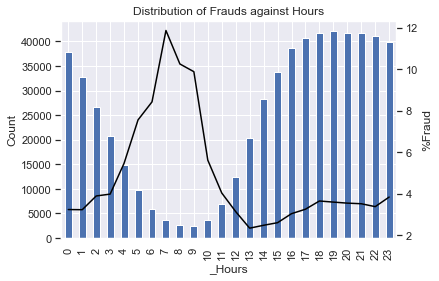

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
final['Transaction count'].plot.bar(ax=ax1)
ax1.set_ylabel('Count')

ax2 = ax1.twinx()
ax2.plot(final['%Fraud'],color='black')
ax2.set_ylabel('%Fraud')
plt.grid(None) 
plt.title("Distribution of Frauds against Hours")

#plt.savefig("asd.png")

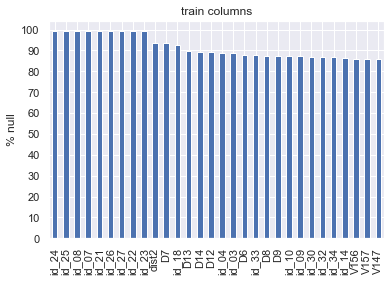

In [9]:
percent_missing = train.isnull().sum() * 100 / len(train)
percent_missing.sort_values(ascending=False).head(30).plot.bar(yticks = range(0,110,10))
plt.title("train columns")
plt.ylabel("% null")
plt.savefig("null_graph_train.png")


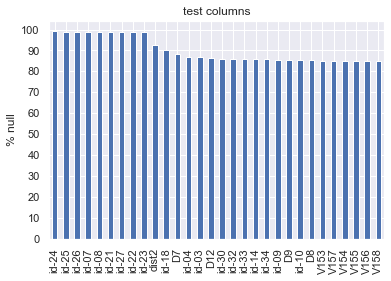

In [10]:
percent_missing = test.isnull().sum() * 100 / len(test)
percent_missing.sort_values(ascending=False).head(30).plot.bar(yticks = range(0,110,10))
plt.title("test columns")
plt.ylabel("% null")
plt.savefig("null_graph_test.png")


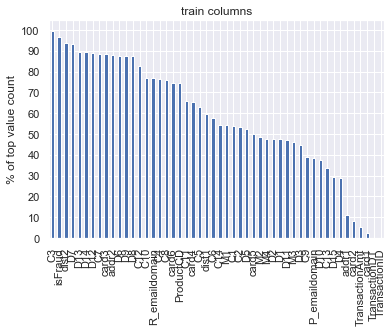

In [11]:
train_dict={}

for col in train.columns:
    train_dict[col]=(train[col].value_counts(dropna=False, normalize=True).values[0]*100)
    
tmps = pd.Series(train_dict, name='count')
tmps.head(50).sort_values(ascending=False).plot.bar(yticks = range(0,110,10))
plt.title("train columns")
plt.ylabel("% of top value count")
plt.savefig("value_proportion_train.png")

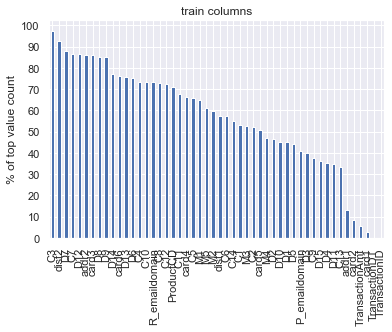

In [12]:
test_dict={}

for col in test.columns:
    test_dict[col]=(test[col].value_counts(dropna=False, normalize=True).values[0]*100)
    
tmps = pd.Series(test_dict, name='count')
tmps.head(50).sort_values(ascending=False).plot.bar(yticks = range(0,110,10))
plt.title("train columns")
plt.ylabel("% of top value count")
plt.savefig("value_proportion_test.png")

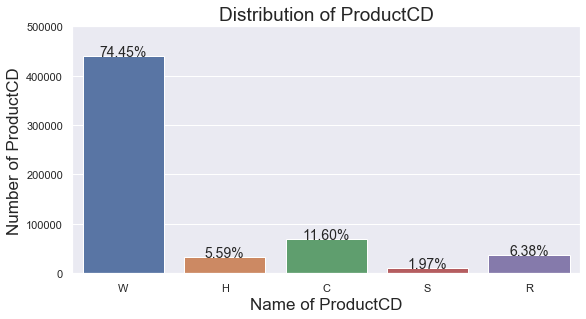

In [13]:
total = len(train)
tmp = pd.crosstab(train['ProductCD'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(20,10))

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=train)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("Distribution of ProductCD", fontsize=19)
g.set_xlabel("Name of ProductCD", fontsize=17)
g.set_ylabel("Number of ProductCD", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14)

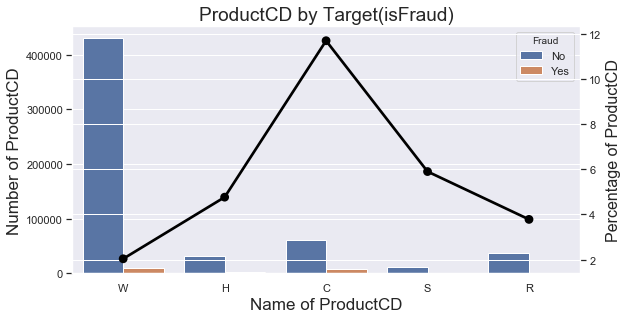

In [14]:
tmp = pd.crosstab(train['ProductCD'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(20,10))

plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=train)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', legend=False, order=['W','H','C','S','R'])
gt.set_ylabel("Percentage of ProductCD", fontsize=16)
g1.set_title("ProductCD by Target(isFraud)", fontsize=19)
g1.set_xlabel("Name of ProductCD", fontsize=17)
g1.set_ylabel("Number of ProductCD", fontsize=17)

plt.show()

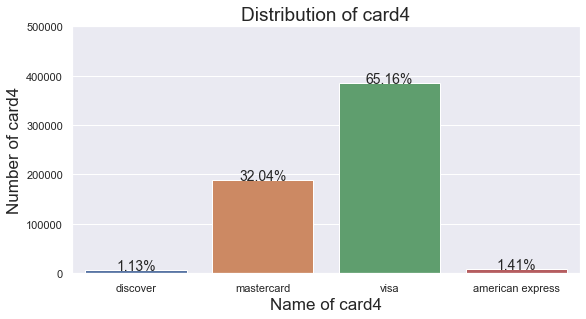

In [15]:
total = len(train)
tmp = pd.crosstab(train['card4'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(20,10))

plt.subplot(221)
g = sns.countplot(x='card4', data=train)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("Distribution of card4", fontsize=19)
g.set_xlabel("Name of card4", fontsize=17)
g.set_ylabel("Number of card4", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14)

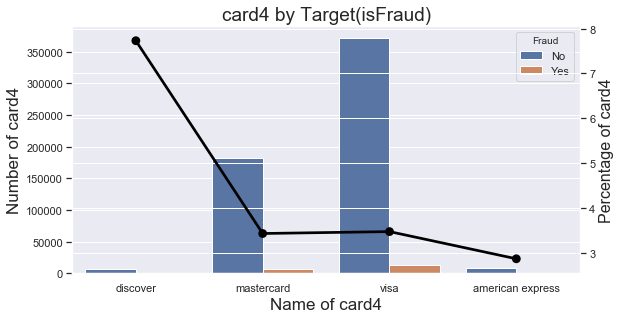

In [16]:
tmp = pd.crosstab(train['card4'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(20,10))

plt.subplot(222)
g1 = sns.countplot(x='card4', hue='isFraud', data=train)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card4', y='Fraud', data=tmp, color='black', legend=False, order=['discover','mastercard','visa','american express'])
gt.set_ylabel("Percentage of card4", fontsize=16)
g1.set_title("card4 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Name of card4", fontsize=17)
g1.set_ylabel("Number of card4", fontsize=17)

plt.show()

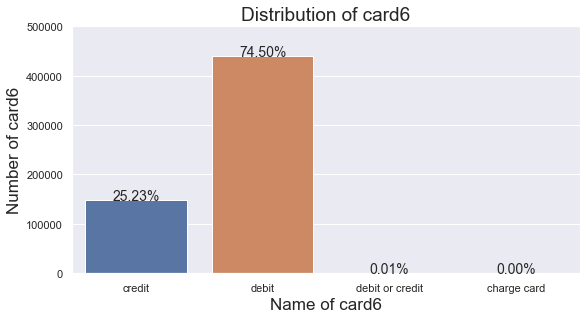

In [17]:
total = len(train)
tmp = pd.crosstab(train['card6'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(20,10))

plt.subplot(221)
g = sns.countplot(x='card6', data=train)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("Distribution of card6", fontsize=19)
g.set_xlabel("Name of card6", fontsize=17)
g.set_ylabel("Number of card6", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14)

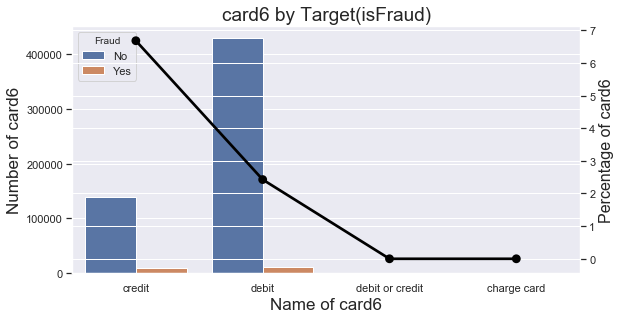

In [18]:
tmp = pd.crosstab(train['card6'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(20,10))
plt.subplot(222)
g1 = sns.countplot(x='card6', hue='isFraud', data=train)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card6', y='Fraud', data=tmp, color='black', legend=False, order=['credit','debit','debit or credit','charge card'])
gt.set_ylabel("Percentage of card6", fontsize=16)
g1.set_title("card6 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Name of card6", fontsize=17)
g1.set_ylabel("Number of card6", fontsize=17)

plt.show()

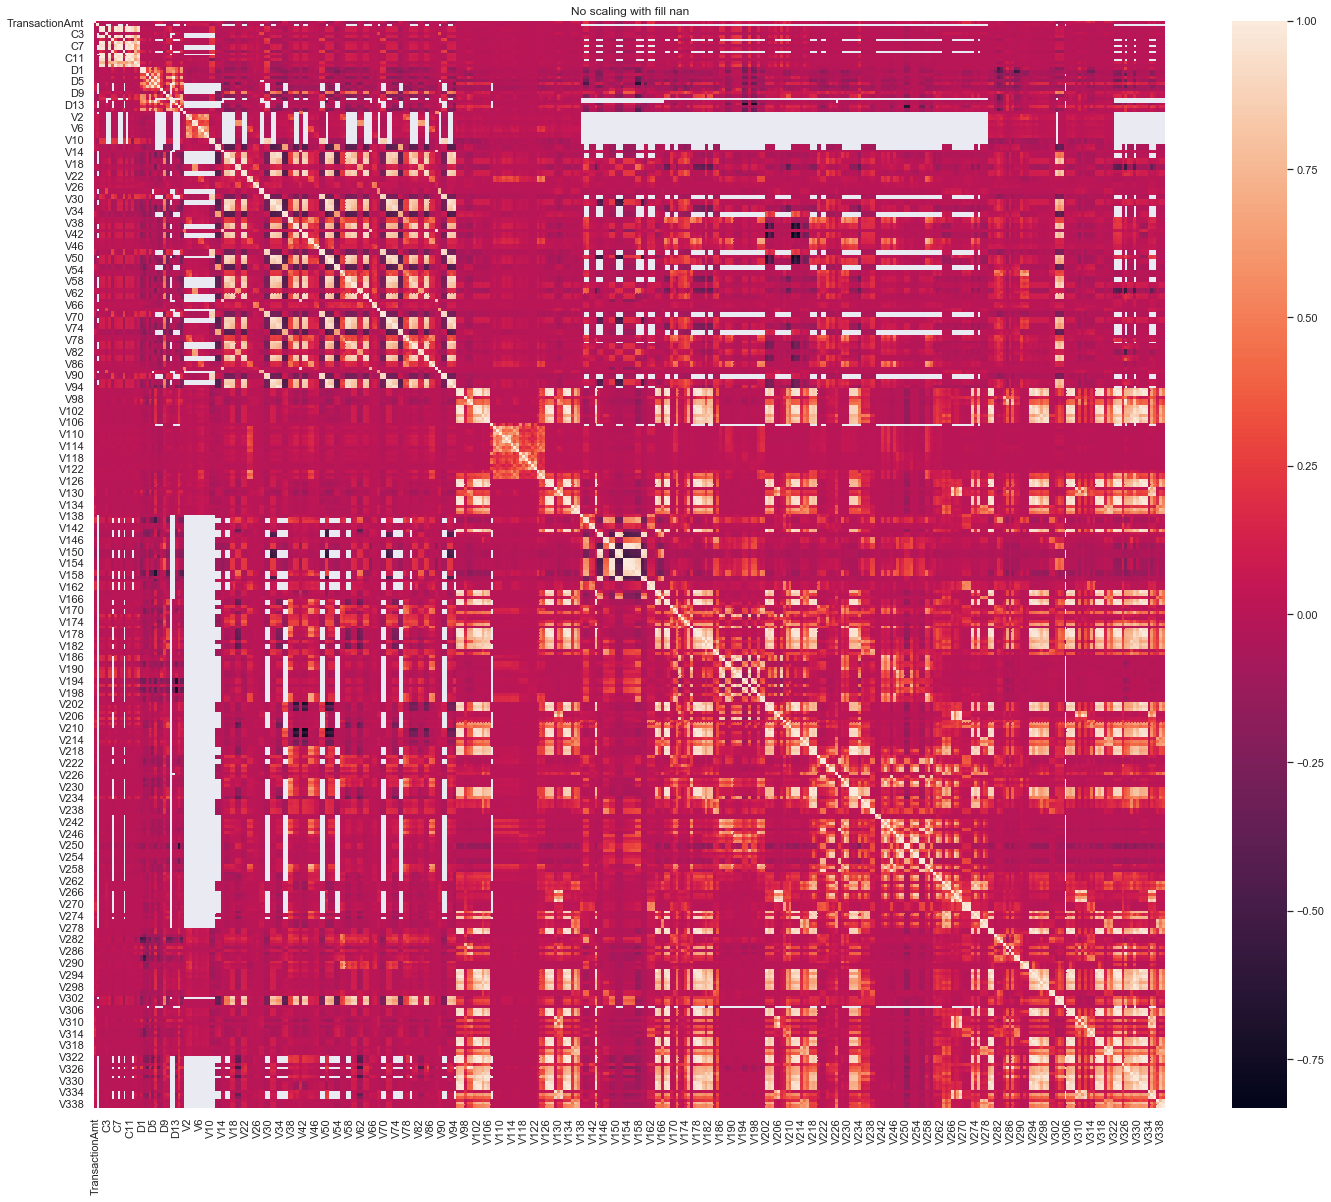

In [19]:
continuous = ['TransactionAmt','dist1'] + list(train.filter(regex='^C[0-9]')) + list(train.filter(regex='^D[0-9]')) + list(train.filter(regex='^V'))
def fill_nan(df):
    for x in list(df.columns.values):
        if x in continuous:
            df[x] = df[x].fillna(df[x].mean())
    return df
train_1 = train.copy()
train_1 = fill_nan(train)
corr=train_1[continuous].corr()
plt.figure(figsize = (24,20))
plt.title("No scaling with fill nan")
sns.heatmap(corr)